# Manuscript Figures
Created by Ivan Lima on Wed Jan 26 2022 10:51:31 -0500

In [38]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings, cmocean
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Jul 25 16:51:19 2023


In [39]:
# sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
import sns_settings
sns.set_context('paper')
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')
dpi = 600

## Temporal distribution of bottle & CTD data

In [40]:
# df_wod = pd.read_hdf('data/bgc_surface_2013-2019.h5')
# df_wod

In [41]:
# read bottle data
df_bottle = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df_bottle.loc[df_bottle.Date.dt.month.isin([1,2,12]),'Season'] = 'Winter' # set seasons
df_bottle.loc[df_bottle.Date.dt.month.isin([3,4,5]),'Season'] = 'Spring'
df_bottle.loc[df_bottle.Date.dt.month.isin([6,7,8]),'Season'] = 'Summer'
df_bottle.loc[df_bottle.Date.dt.month.isin([9,10,11]),'Season'] = 'Fall'

# read CTD data
# df_wod = pd.read_hdf('data/bgc_all_2013-2019.h5', key='df_wod_bgc')
df_wod = pd.read_hdf('data/bgc_surface_2013-2019.h5')
# convert seasons to uppercase
for s in ['winter','spring','summer','fall']:
    df_wod.loc[df_wod.season==s,'season'] = s.title()

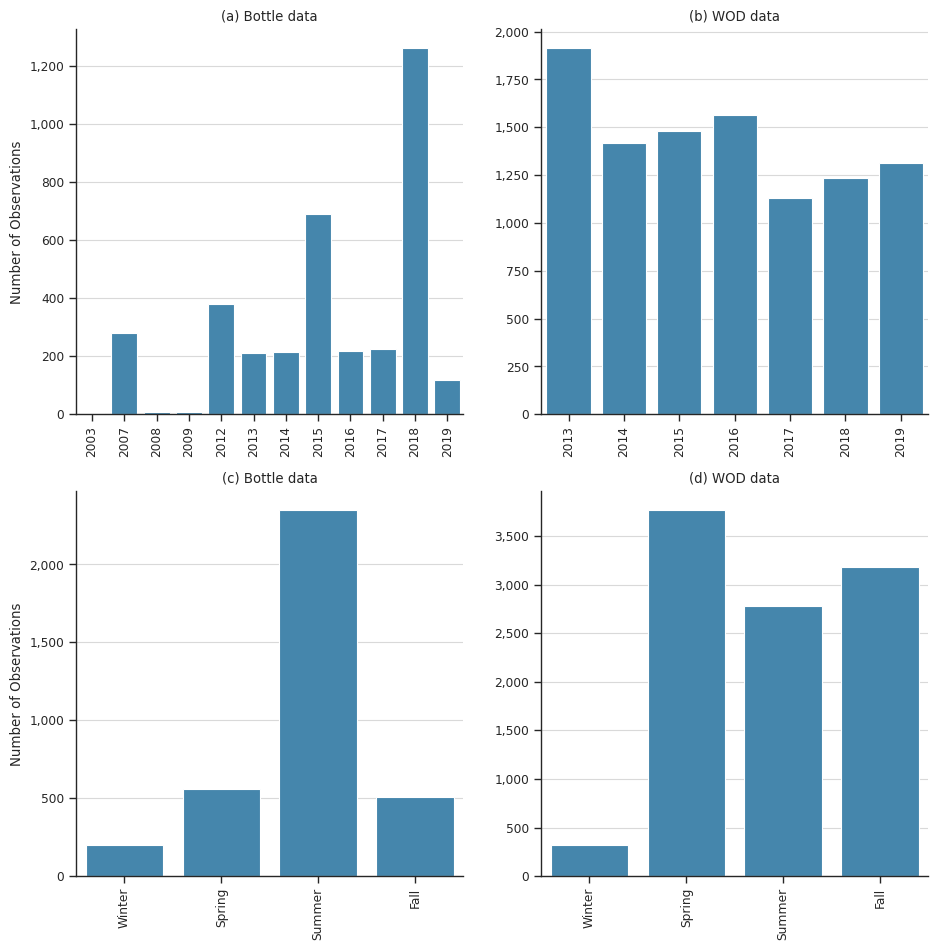

In [42]:
from matplotlib import ticker
fmt = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))

s_bottle = df_bottle.groupby('Year')['TA'].count().to_frame().reset_index()
s_ctd = df_wod.groupby(df_wod.Date.dt.year)['TA'].count().to_frame().reset_index()

seasons = ['Winter','Spring','Summer','Fall']
s_bottle_season = df_bottle.groupby('Season')['TA'].count().to_frame().reindex(seasons).reset_index()
s_ctd_season = df_wod.groupby('season')['TA'].count().to_frame().reindex(seasons).reset_index()

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
_ = sns.barplot(data=s_bottle, x='Year', y='TA', color='C0', ax=axs[0,0])
_ = axs[0,0].set_xticklabels(s_bottle.Year, rotation=90)
_ = axs[0,0].set(xlabel='', ylabel='Number of Observations', title='(a) Bottle data')
_ = axs[0,0].yaxis.set_major_formatter(fmt)
_ = sns.barplot(data=s_ctd, x='Date', y='TA', color='C0', ax=axs[0,1])
_ = axs[0,1].set_xticklabels(s_ctd.Date, rotation=90)
_ = axs[0,1].set(xlabel='', ylabel='', title='(b) WOD data')
_ = axs[0,1].yaxis.set_major_formatter(fmt)

_ = sns.barplot(data=s_bottle_season, x='Season', y='TA', color='C0', ax=axs[1,0])
_ = axs[1,0].set_xticklabels(seasons, rotation=90)
_ = axs[1,0].set(xlabel='', ylabel='Number of Observations', title='(c) Bottle data')
_ = axs[1,0].yaxis.set_major_formatter(fmt)
_ = sns.barplot(data=s_ctd_season, x='season', y='TA', color='C0', ax=axs[1,1])
_ = axs[1,1].set_xticklabels(seasons, rotation=90)
_ = axs[1,1].set(xlabel='', ylabel='', title='(d) WOD data')
_ = axs[1,1].yaxis.set_major_formatter(fmt)

sns.despine(fig)
fig.savefig('figures/data_distribution_time.png', dpi=dpi, bbox_inches='tight')

## Model accuracy on test set

In [43]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df_test = pd.read_csv('data/pytorch_bottle_test.csv', index_col=0)
df_test_noO2 = pd.read_csv('data/pytorch_bottle_test_noO2.csv', index_col=0)
df_test_no_sat = pd.read_csv('data/pytorch_bottle_test_no_sat.csv', index_col=0)

true, pred = ['DIC_test','TA_test'], ['DIC_pred_test','TA_pred_test']

r2_vals, rmse_vals = [], []
for df in [df_test, df_test_noO2, df_test_no_sat]:
    r2_vals.append(r2_score(df[true], df[pred]))
    rmse_vals.append(mean_squared_error(df[true], df[pred], squared=False))

stats = pd.DataFrame({'R_squared': r2_vals, 'RMSE': rmse_vals}, index=['all features', '- DO', '- DO - sat'])
print('Combined regression stats for DIC and TA') 
stats.style.format('{:.3f}')

Combined regression stats for DIC and TA


,R_squared,RMSE
all features,0.975,11.350
- DO,0.971,12.004
- DO - sat,0.966,12.929


In [44]:
r2_vals, rmse_vals = [], []
for df in [df_test, df_test_noO2, df_test_no_sat]:
    r2_vals.append(r2_score(df.DIC_test, df.DIC_pred_test))
    rmse_vals.append(mean_squared_error(df.DIC_test, df.DIC_pred_test, squared=False))

stats_dic = pd.DataFrame({'R_squared': r2_vals, 'RMSE': rmse_vals}, index=['all features', '- DO', '- DO - sat'])
print('Regression stats for DIC') 
stats_dic.style.format('{:.3f}')

Regression stats for DIC


,R_squared,RMSE
all features,0.963,14.149
- DO,0.956,15.370
- DO - sat,0.947,16.956


In [45]:
r2_vals, rmse_vals = [], []
for df in [df_test, df_test_noO2, df_test_no_sat]:
    r2_vals.append(r2_score(df.TA_test, df.TA_pred_test))
    rmse_vals.append(mean_squared_error(df.TA_test, df.TA_pred_test, squared=False))

stats_ta = pd.DataFrame({'R_squared': r2_vals, 'RMSE': rmse_vals}, index=['all features', '- DO', '- DO - sat'])
print('Regression stats for TA') 
stats_ta.style.format('{:.3f}')

Regression stats for TA


,R_squared,RMSE
all features,0.987,8.552
- DO,0.987,8.639
- DO - sat,0.986,8.901


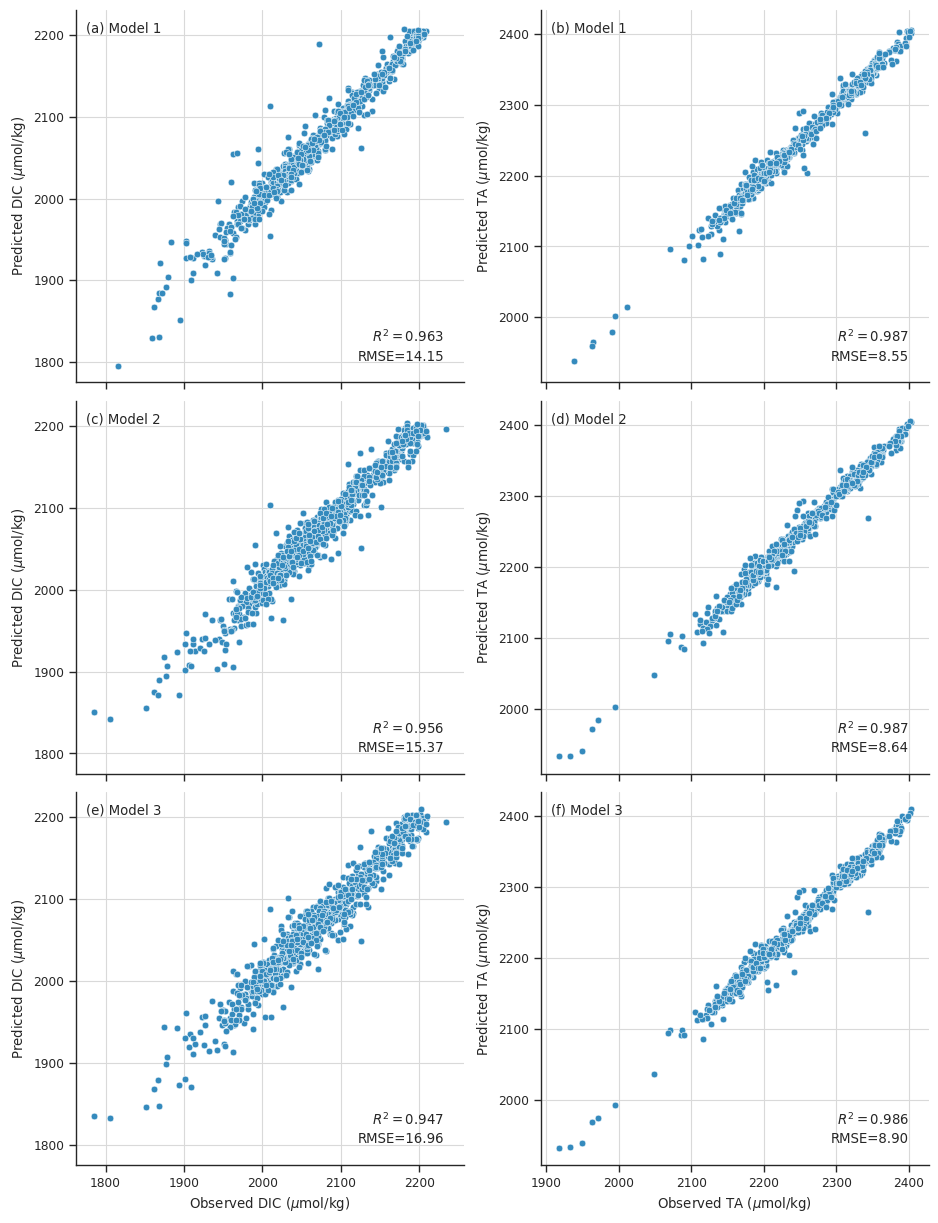

In [46]:
fig, axs = plt.subplots(3, 2, sharex='col', sharey='col', figsize=(11, 15))
fig.subplots_adjust(hspace=0.05)
for df, ax in zip([df_test, df_test_noO2, df_test_no_sat], axs):
    _ = sns.scatterplot(x='DIC_test', y='DIC_pred_test', data=df, ax=ax[0])
    _ = sns.scatterplot(x='TA_test', y='TA_pred_test', data=df, ax=ax[1])

for ax in axs[:,0]:
    ax.set(xlabel='Observed DIC ($\mu$mol/kg)', ylabel='Predicted DIC ($\mu$mol/kg)')
for ax in axs[:,1]:
    ax.set(xlabel='Observed TA ($\mu$mol/kg)', ylabel='Predicted TA ($\mu$mol/kg)')
    
for ax, r2, rmse in zip(axs[:,0], stats_dic.R_squared.values, stats_dic.RMSE.values):
    _ = ax.text(0.95, 0.1, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='right', va='bottom')
    _ = ax.text(0.95, 0.05, 'RMSE={:.2f}'.format(rmse), transform=ax.transAxes, ha='right', va='bottom')

for ax, r2, rmse in zip(axs[:,1], stats_ta.R_squared.values, stats_ta.RMSE.values):
    _ = ax.text(0.95, 0.1, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='right', va='bottom')
    _ = ax.text(0.95, 0.05, 'RMSE={:.2f}'.format(rmse), transform=ax.transAxes, ha='right', va='bottom')

labels = ['(a) Model 1', '(b) Model 1', '(c) Model 2', '(d) Model 2', '(e) Model 3', '(f) Model 3']
for ax, label in zip(axs.ravel(), labels):
    _ = ax.text(0.025, 0.97, '{}'.format(label), transform=ax.transAxes, ha='left', va='top')
    
sns.despine(fig)

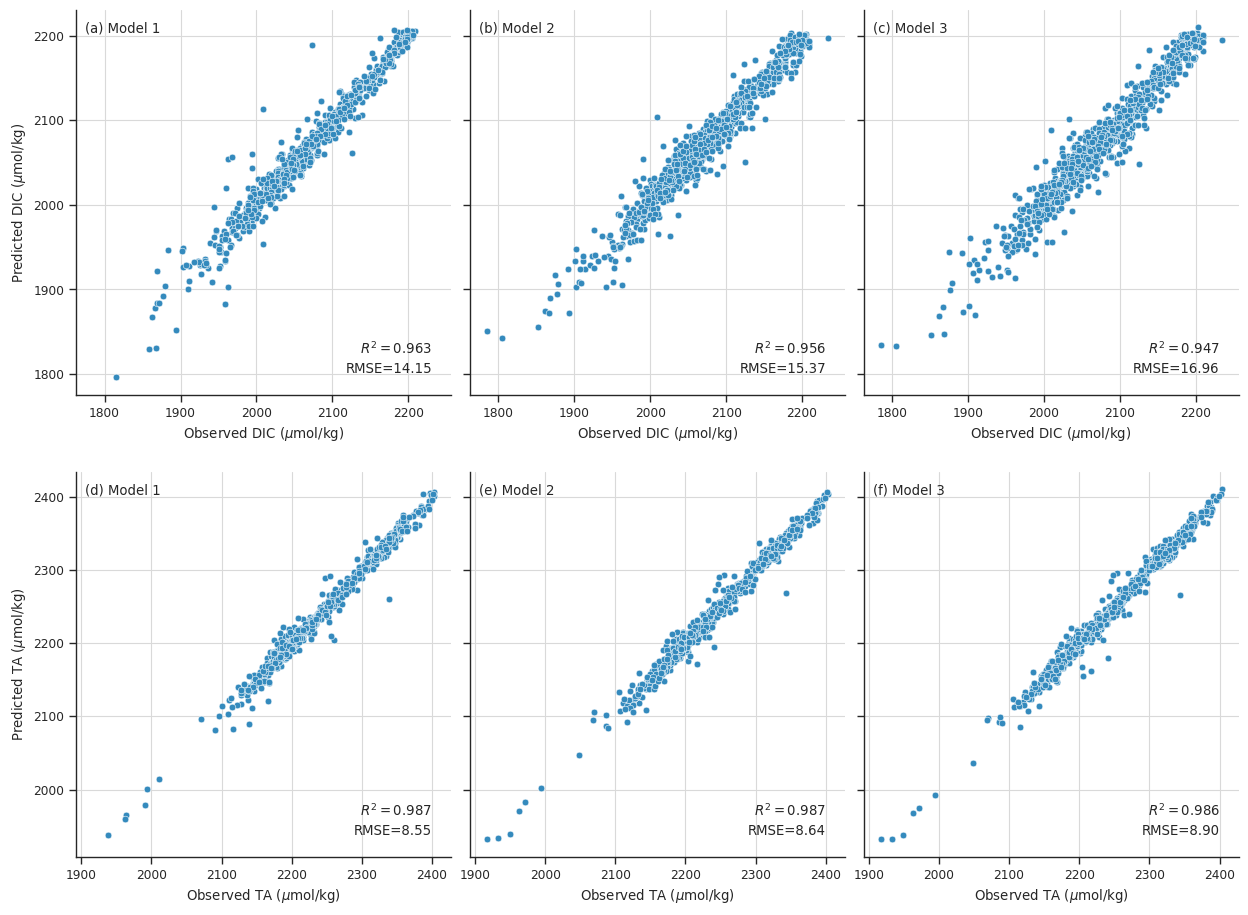

In [47]:
fig, axs = plt.subplots(2, 3, sharex='row', sharey='row', figsize=(15, 11))
fig.subplots_adjust(wspace=0.05)
for df, ax in zip([df_test, df_test_noO2, df_test_no_sat], axs[0]):
    _ = sns.scatterplot(x='DIC_test', y='DIC_pred_test', data=df, ax=ax)
for df, ax in zip([df_test, df_test_noO2, df_test_no_sat], axs[1]):
    _ = sns.scatterplot(x='TA_test', y='TA_pred_test', data=df, ax=ax)

for ax in axs[0,:]:
    ax.set(xlabel='Observed DIC ($\mu$mol/kg)', ylabel='Predicted DIC ($\mu$mol/kg)')
for ax in axs[1,:]:
    ax.set(xlabel='Observed TA ($\mu$mol/kg)', ylabel='Predicted TA ($\mu$mol/kg)')

for ax, r2, rmse in zip(axs[0,:], stats_dic.R_squared.values, stats_dic.RMSE.values):
    _ = ax.text(0.95, 0.1, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='right', va='bottom')
    _ = ax.text(0.95, 0.05, 'RMSE={:.2f}'.format(rmse), transform=ax.transAxes, ha='right', va='bottom')

for ax, r2, rmse in zip(axs[1,:], stats_ta.R_squared.values, stats_ta.RMSE.values):
    _ = ax.text(0.95, 0.1, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='right', va='bottom')
    _ = ax.text(0.95, 0.05, 'RMSE={:.2f}'.format(rmse), transform=ax.transAxes, ha='right', va='bottom')

labels = ['(a) Model 1', '(b) Model 2', '(c) Model 3', '(d) Model 1', '(e) Model 2', '(f) Model 3']
for ax, label in zip(axs.ravel(), labels):
    _ = ax.text(0.025, 0.97, '{}'.format(label), transform=ax.transAxes, ha='left', va='top')
    
sns.despine(fig)
fig.savefig('figures/nn_fit_test_set.png', dpi=dpi, bbox_inches='tight')

## Model uncertainty

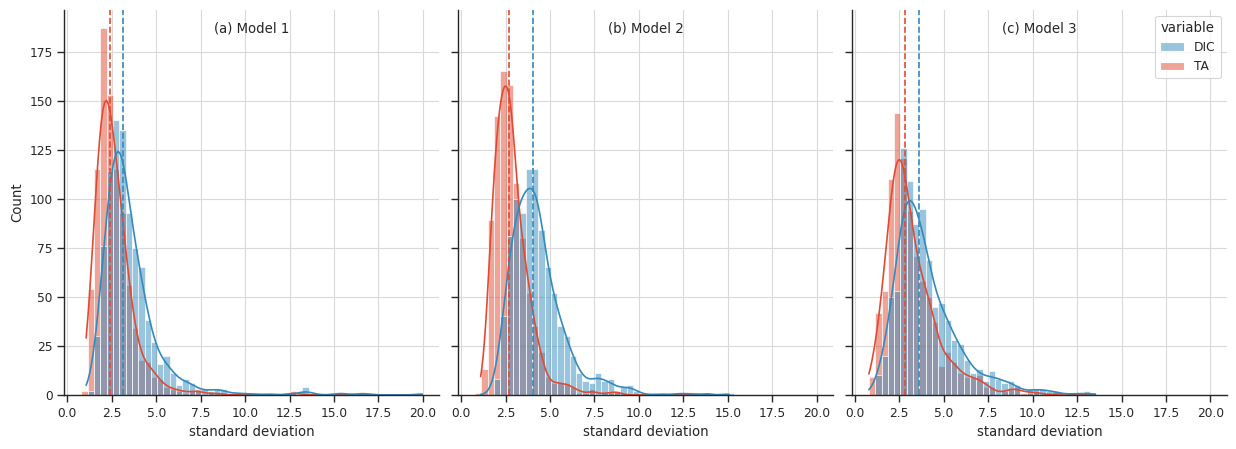

In [48]:
df_uncert = pd.read_csv('data/uncertainty_testset.csv', index_col=0)
df_uncert_noO2 = pd.read_csv('data/uncertainty_testset_noO2.csv', index_col=0)
df_uncert_no_sat = pd.read_csv('data/uncertainty_testset_no_sat.csv', index_col=0)

std_min = np.min([df_uncert.std_DIC.min(), df_uncert.std_TA.min(),
                  df_uncert_noO2.std_DIC.min(), df_uncert_noO2.std_TA.min(),
                  df_uncert_no_sat.std_DIC.min(), df_uncert_no_sat.std_TA.min()])

std_max = np.max([df_uncert.std_DIC.max(), df_uncert.std_TA.max(),
                  df_uncert_noO2.std_DIC.max(), df_uncert_noO2.std_TA.max(),
                  df_uncert_no_sat.std_DIC.max(), df_uncert_no_sat.std_TA.max()])

def reformat(df_in):
    df_work = df_in[['std_DIC','std_TA']].rename(columns={'std_DIC':'DIC','std_TA':'TA'}).stack().reset_index(level=1)
    df_out = df_work.rename(columns={'level_1':'variable', 0:'std'}).reset_index(drop=True)
    return df_out

df1 = reformat(df_uncert)
df2 = reformat(df_uncert_noO2)
df3 = reformat(df_uncert_no_sat)

mdic = [df.std_DIC.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]
mta = [df.std_TA.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]

# bins = np.histogram_bin_edges(df1['std'], bins='auto')
bins = np.linspace(std_min, std_max, 55)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
fig.subplots_adjust(wspace=0.05)
for ax, df, leg, md, ma in zip(axs.ravel(), [df1, df2, df3], [False, False, True], mdic, mta):
    _ = sns.histplot(x='std', data=df, hue='variable', kde=True, bins=bins, ax=ax, legend=leg)
    _ = ax.set(xlabel='standard deviation')
    _ = ax.axvline(md, c='C0', ls='--')
    _ = ax.axvline(ma, c='C1', ls='--')
    
for ax, lab in zip(axs.ravel(), ['(a) Model 1', '(b) Model 2', '(c) Model 3']):
    _ = ax.text(0.5, 0.97, '{}'.format(lab), transform=ax.transAxes, ha='center', va='top')

sns.despine(fig)
# fig.savefig('figures/model_uncertainty.png', dpi=dpi, bbox_inches='tight')

In [49]:
dic_std = [
    [df_uncert.std_DIC.min(), df_uncert.std_DIC.max(), df_uncert.std_DIC.median()],
    [df_uncert_noO2.std_DIC.min(), df_uncert_noO2.std_DIC.max(), df_uncert_noO2.std_DIC.median()],
    [df_uncert_no_sat.std_DIC.min(), df_uncert_no_sat.std_DIC.max(), df_uncert_no_sat.std_DIC.median()]
]
pd.DataFrame(dic_std, columns=['DIC $\sigma$ min','DIC $\sigma$ max','DIC $\sigma$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,DIC $\sigma$ min,DIC $\sigma$ max,DIC $\sigma$ median
Model 1,1.460,15.462,3.136
Model 2,1.950,15.053,4.051
Model 3,1.294,13.091,3.613


In [50]:
ta_std = [
    [df_uncert.std_TA.min(), df_uncert.std_TA.max(), df_uncert.std_TA.median()],
    [df_uncert_noO2.std_TA.min(), df_uncert_noO2.std_TA.max(), df_uncert_noO2.std_TA.median()],
    [df_uncert_no_sat.std_TA.min(), df_uncert_no_sat.std_TA.max(), df_uncert_no_sat.std_TA.median()]
]
pd.DataFrame(ta_std, columns=['TA $\sigma$ min','TA $\sigma$ max','TA $\sigma$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,TA $\sigma$ min,TA $\sigma$ max,TA $\sigma$ median
Model 1,1.057,19.966,2.417
Model 2,1.100,13.852,2.669
Model 3,0.789,13.527,2.833


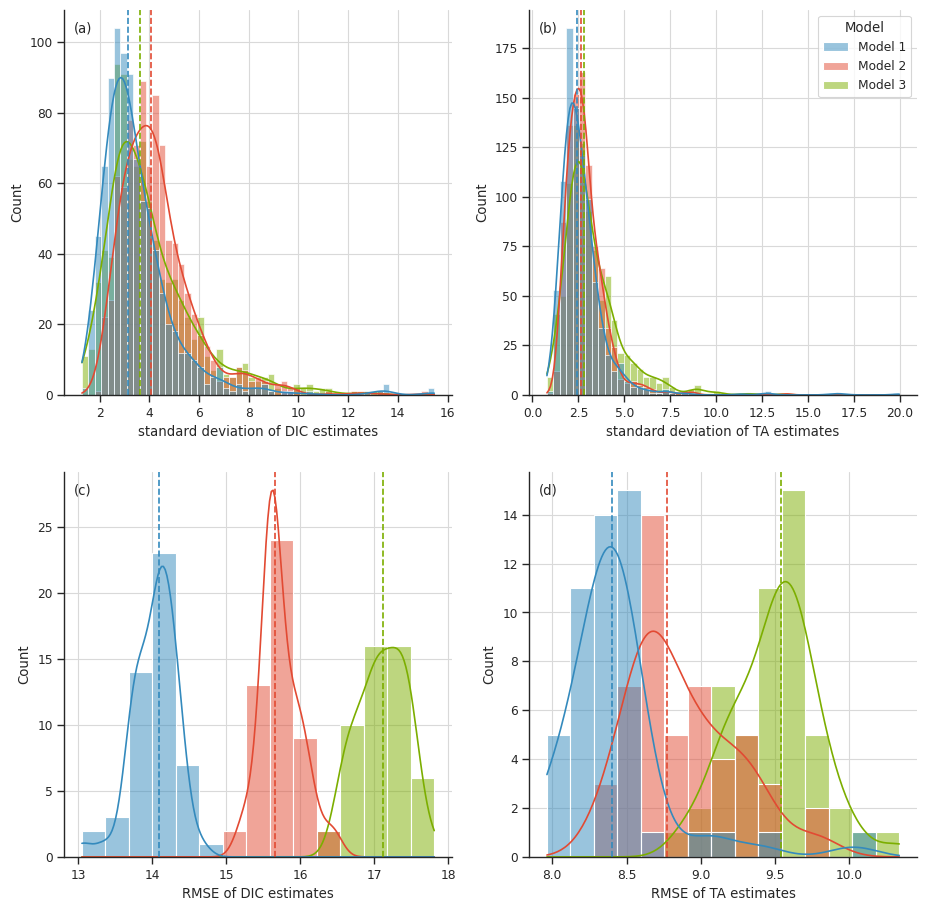

In [51]:
df_ensemble = pd.read_csv('data/ensemble_testset.csv', index_col=0)
df_ensemble_noO2 = pd.read_csv('data/ensemble_testset_noO2.csv', index_col=0)
df_ensemble_no_sat = pd.read_csv('data/ensemble_testset_no_sat.csv', index_col=0)

df_ensemble_dic = pd.DataFrame({'Model 1': df_ensemble.rmse_DIC, 'Model 2': df_ensemble_noO2.rmse_DIC, 'Model 3': df_ensemble_no_sat.rmse_DIC})
df_ensemble_ta = pd.DataFrame({'Model 1': df_ensemble.rmse_TA, 'Model 2': df_ensemble_noO2.rmse_TA, 'Model 3': df_ensemble_no_sat.rmse_TA})

df_ensemble_dic = pd.melt(df_ensemble_dic, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'RMSE'})
df_ensemble_ta = pd.melt(df_ensemble_ta, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'RMSE'})

m_ens_dic = [df.rmse_DIC.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]
m_ens_ta = [df.rmse_TA.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]

df_dic = pd.DataFrame({'Model 1': df_uncert['std_DIC'], 'Model 2': df_uncert_noO2['std_DIC'],
                       'Model 3': df_uncert_no_sat['std_DIC']})
df_ta = pd.DataFrame({'Model 1': df_uncert['std_TA'], 'Model 2': df_uncert_noO2['std_TA'],
                      'Model 3': df_uncert_no_sat['std_TA']})

df_dic = pd.melt(df_dic, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'std'})
df_ta = pd.melt(df_ta, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'std'})

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
_ = sns.histplot(x='std', data=df_dic, hue='Model', kde=True, bins=55, ax=axs[0,0], legend=False)
_ = sns.histplot(x='std', data=df_ta, hue='Model', kde=True, bins=55, ax=axs[0,1], legend=True)
_ = sns.histplot(x='RMSE', data=df_ensemble_dic, hue='Model', kde=True, bins=15, ax=axs[1,0], legend=False)
_ = sns.histplot(x='RMSE', data=df_ensemble_ta, hue='Model', kde=True, bins=15, ax=axs[1,1], legend=False)
for md, c in zip(mdic, ['C0','C1','C2']):
    _ = axs[0,0].axvline(md, c=c, ls='--')
for md, c in zip(mta, ['C0','C1','C2']):
    _ = axs[0,1].axvline(md, c=c, ls='--')
for md, c in zip(m_ens_dic, ['C0','C1','C2']):
    _ = axs[1,0].axvline(md, c=c, ls='--')
for md, c in zip(m_ens_ta, ['C0','C1','C2']):
    _ = axs[1,1].axvline(md, c=c, ls='--')
for ax, lab in zip(axs.ravel(), ['(a)', '(b)', '(c)', '(d)']):
    _ = ax.text(0.025, 0.97, '{}'.format(lab), transform=ax.transAxes, ha='left', va='top')
_ = axs[0,0].set(xlabel='standard deviation of DIC estimates')
_ = axs[0,1].set(xlabel='standard deviation of TA estimates')
_ = axs[1,0].set(xlabel='RMSE of DIC estimates')
_ = axs[1,1].set(xlabel='RMSE of TA estimates')

sns.despine(fig)
fig.savefig('figures/model_uncertainty.png', dpi=dpi, bbox_inches='tight')

In [52]:
dic_rmse = [
    [df_ensemble.rmse_DIC.min(), df_ensemble.rmse_DIC.max(), df_ensemble.rmse_DIC.median()],
    [df_ensemble_noO2.rmse_DIC.min(), df_ensemble_noO2.rmse_DIC.max(), df_ensemble_noO2.rmse_DIC.median()],
    [df_ensemble_no_sat.rmse_DIC.min(), df_ensemble_no_sat.rmse_DIC.max(), df_ensemble_no_sat.rmse_DIC.median()]
]
pd.DataFrame(dic_rmse, columns=['DIC RMSE min','DIC RMSE max','DIC RMSE median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,DIC RMSE min,DIC RMSE max,DIC RMSE median
Model 1,13.052,14.646,14.094
Model 2,15.190,16.476,15.661
Model 3,16.489,17.807,17.117


In [53]:
ta_rmse = [
    [df_ensemble.rmse_TA.min(), df_ensemble.rmse_TA.max(), df_ensemble.rmse_TA.median()],
    [df_ensemble_noO2.rmse_TA.min(), df_ensemble_noO2.rmse_TA.max(), df_ensemble_noO2.rmse_TA.median()],
    [df_ensemble_no_sat.rmse_TA.min(), df_ensemble_no_sat.rmse_TA.max(), df_ensemble_no_sat.rmse_TA.median()]
]
pd.DataFrame(ta_rmse, columns=['TA RMSE min','TA RMSE max','TA RMSE median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,TA RMSE min,TA RMSE max,TA RMSE median
Model 1,7.964,10.028,8.400
Model 2,8.328,9.774,8.771
Model 3,8.895,10.336,9.539


### $R^2$

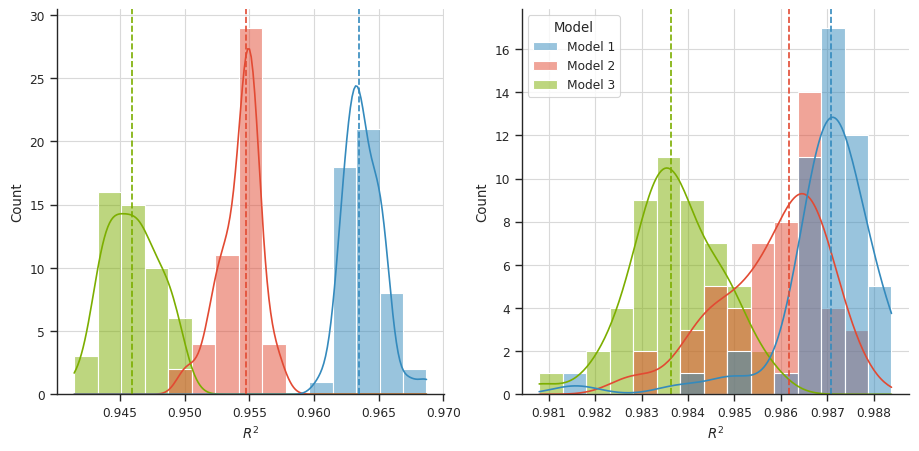

In [54]:
df_ensemble_dic2 = pd.DataFrame({'Model 1': df_ensemble.r2_DIC, 'Model 2': df_ensemble_noO2.r2_DIC, 'Model 3': df_ensemble_no_sat.r2_DIC})
df_ensemble_ta2 = pd.DataFrame({'Model 1': df_ensemble.r2_TA, 'Model 2': df_ensemble_noO2.r2_TA, 'Model 3': df_ensemble_no_sat.r2_TA})

df_ensemble_dic2 = pd.melt(df_ensemble_dic2, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'$R^2$'})
df_ensemble_ta2 = pd.melt(df_ensemble_ta2, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'$R^2$'})

m_ens_dic2 = [df.r2_DIC.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]
m_ens_ta2 = [df.r2_TA.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.histplot(x='$R^2$', data=df_ensemble_dic2, hue='Model', kde=True, bins=15, ax=axs[0], legend=False)
_ = sns.histplot(x='$R^2$', data=df_ensemble_ta2, hue='Model', kde=True, bins=15, ax=axs[1], legend=True)
for md, c in zip(m_ens_dic2, ['C0','C1','C2']):
    _ = axs[0].axvline(md, c=c, ls='--')
for md, c in zip(m_ens_ta2, ['C0','C1','C2']):
    _ = axs[1].axvline(md, c=c, ls='--')
sns.despine(fig)

In [55]:
dic_r2 = [
    [df_ensemble.r2_DIC.min(), df_ensemble.r2_DIC.max(), df_ensemble.r2_DIC.median()],
    [df_ensemble_noO2.r2_DIC.min(), df_ensemble_noO2.r2_DIC.max(), df_ensemble_noO2.r2_DIC.median()],
    [df_ensemble_no_sat.r2_DIC.min(), df_ensemble_no_sat.r2_DIC.max(), df_ensemble_no_sat.r2_DIC.median()]
]
pd.DataFrame(dic_r2, columns=['DIC $R^2$ min','DIC $R^2$ max','DIC $R^2$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,DIC $R^2$ min,DIC $R^2$ max,DIC $R^2$ median
Model 1,0.961,0.969,0.963
Model 2,0.950,0.957,0.955
Model 3,0.941,0.950,0.946


In [56]:
ta_r2 = [
    [df_ensemble.r2_TA.min(), df_ensemble.r2_TA.max(), df_ensemble.r2_TA.median()],
    [df_ensemble_noO2.r2_TA.min(), df_ensemble_noO2.r2_TA.max(), df_ensemble_noO2.r2_TA.median()],
    [df_ensemble_no_sat.r2_TA.min(), df_ensemble_no_sat.r2_TA.max(), df_ensemble_no_sat.r2_TA.median()]
]
pd.DataFrame(ta_r2, columns=['TA $R^2$ min','TA $R^2$ max','TA $R^2$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,TA $R^2$ min,TA $R^2$ max,TA $R^2$ median
Model 1,0.982,0.988,0.987
Model 2,0.983,0.988,0.986
Model 3,0.981,0.986,0.984


### Coefficient of variation

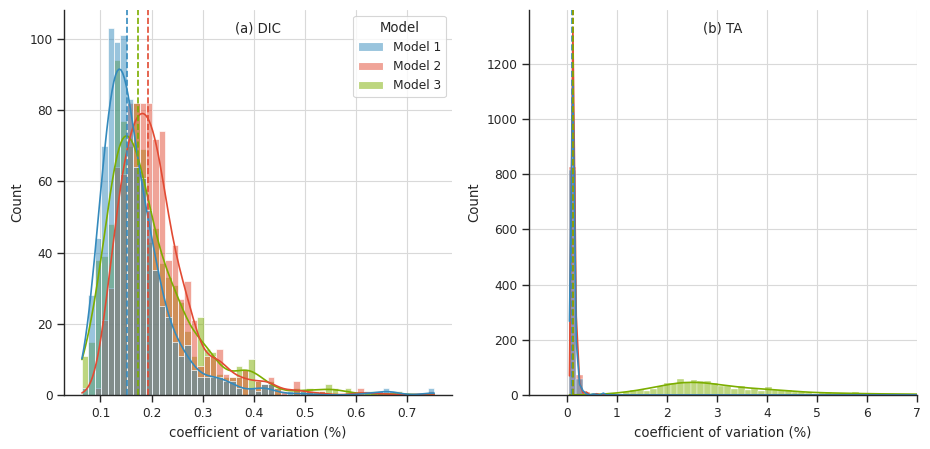

In [57]:
for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]:
    df['cv_DIC'] = df.std_DIC / df.avg_DIC * 100
    df['cv_TA'] = df.std_TA / df.avg_TA * 100

df_dic = pd.DataFrame({'Model 1': df_uncert['cv_DIC'],
                       'Model 2': df_uncert_noO2['cv_DIC'],
                       'Model 3': df_uncert_no_sat['cv_DIC']})
df_ta = pd.DataFrame({'Model 1': df_uncert['cv_TA'],
                      'Model 2': df_uncert_noO2['cv_TA'],
                      'Model 3': df_uncert_no_sat['std_TA']})

df_dic2 = pd.melt(df_dic, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'cv'})
df_ta2 = pd.melt(df_ta, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'cv'})

cdic = [df.cv_DIC.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]
cta = [df.cv_TA.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.histplot(x='cv', data=df_dic2, hue='Model', kde=True, bins=55, ax=axs[0], legend=True)
_ = sns.histplot(x='cv', data=df_ta2, hue='Model', kde=True, bins=100, ax=axs[1], legend=False)
_ = axs[1].set_xlim(-0.755, 7)
for md, c in zip(cdic, ['C0','C1','C2']):
    _ = axs[0].axvline(md, c=c, ls='--')
for md, c in zip(cta, ['C0','C1','C2']):
    _ = axs[1].axvline(md, c=c, ls='--')
for ax, lab in zip(axs.ravel(), ['(a) DIC', '(b) TA']):
    _ = ax.text(0.5, 0.97, '{}'.format(lab), transform=ax.transAxes, ha='center', va='top')
    _ = ax.set(xlabel='coefficient of variation (%)')
sns.despine(fig)

## Model error 

In [58]:
varlist = ['EXPOCODE', 'Accession', 'Cruise_ID', 'Date', 'Latitude', 'Longitude', 'Season', 'Depth', 'bottom_depth',
           'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'log_KD490', 'DIC', 'TA']
df_bottle_subset = df_bottle[varlist]
df_bottle_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3623 entries, 0 to 3779
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   EXPOCODE       2488 non-null   object        
 1   Accession      1124 non-null   float64       
 2   Cruise_ID      3044 non-null   object        
 3   Date           3623 non-null   datetime64[ns]
 4   Latitude       3623 non-null   float64       
 5   Longitude      3623 non-null   float64       
 6   Season         3623 non-null   object        
 7   Depth          3623 non-null   float64       
 8   bottom_depth   3623 non-null   float64       
 9   Temperature    3623 non-null   float64       
 10  Salinity       3623 non-null   float64       
 11  Oxygen         3533 non-null   float64       
 12  pCO2_monthave  3623 non-null   float64       
 13  SLA            3623 non-null   float64       
 14  SST_hires      3623 non-null   float64       
 15  log_KD490      3623 n

In [59]:
def merge_data(df1, df2, left=['DIC','TA'], right=['DIC_test', 'TA_test']):
    df_new = pd.merge(df1, df2, left_on=left, right_on=right)
    cond_dic =  ((df_new.DIC - df_new.DIC_test).values == 0).all()
    cond_ta = ((df_new.TA - df_new.TA_test).values == 0).all()
    if cond_dic and cond_ta:
        print('DIC & TA match')
        df_new = df_new.drop(['DIC_test','TA_test'], axis=1)
        df_new = df_new.rename(columns={'DIC_pred_test':'DIC_pred', 'TA_pred_test':'TA_pred'})
        df_new['DIC_resid'] = df_new.DIC - df_new.DIC_pred
        df_new['TA_resid'] = df_new.TA - df_new.TA_pred
        return df_new
    
df_merged = merge_data(df_bottle_subset, df_test)
df_merged_noO2 = merge_data(df_bottle_subset, df_test_noO2)
df_merged_no_sat = merge_data(df_bottle_subset, df_test_no_sat)

DIC & TA match
DIC & TA match
DIC & TA match


#### Number of data points per season

In [60]:
for df, m in zip([df_merged, df_merged_noO2, df_merged_no_sat], ['Model 1', 'Model 2', 'Model 3']):
    print('{}\n{}\n'.format(m, df.Season.value_counts()))

Model 1
Summer    558
Fall      156
Spring    134
Winter     50
Name: Season, dtype: int64

Model 2
Summer    597
Fall      146
Spring    130
Winter     47
Name: Season, dtype: int64

Model 3
Summer    597
Fall      146
Spring    130
Winter     47
Name: Season, dtype: int64



### Residuals by season

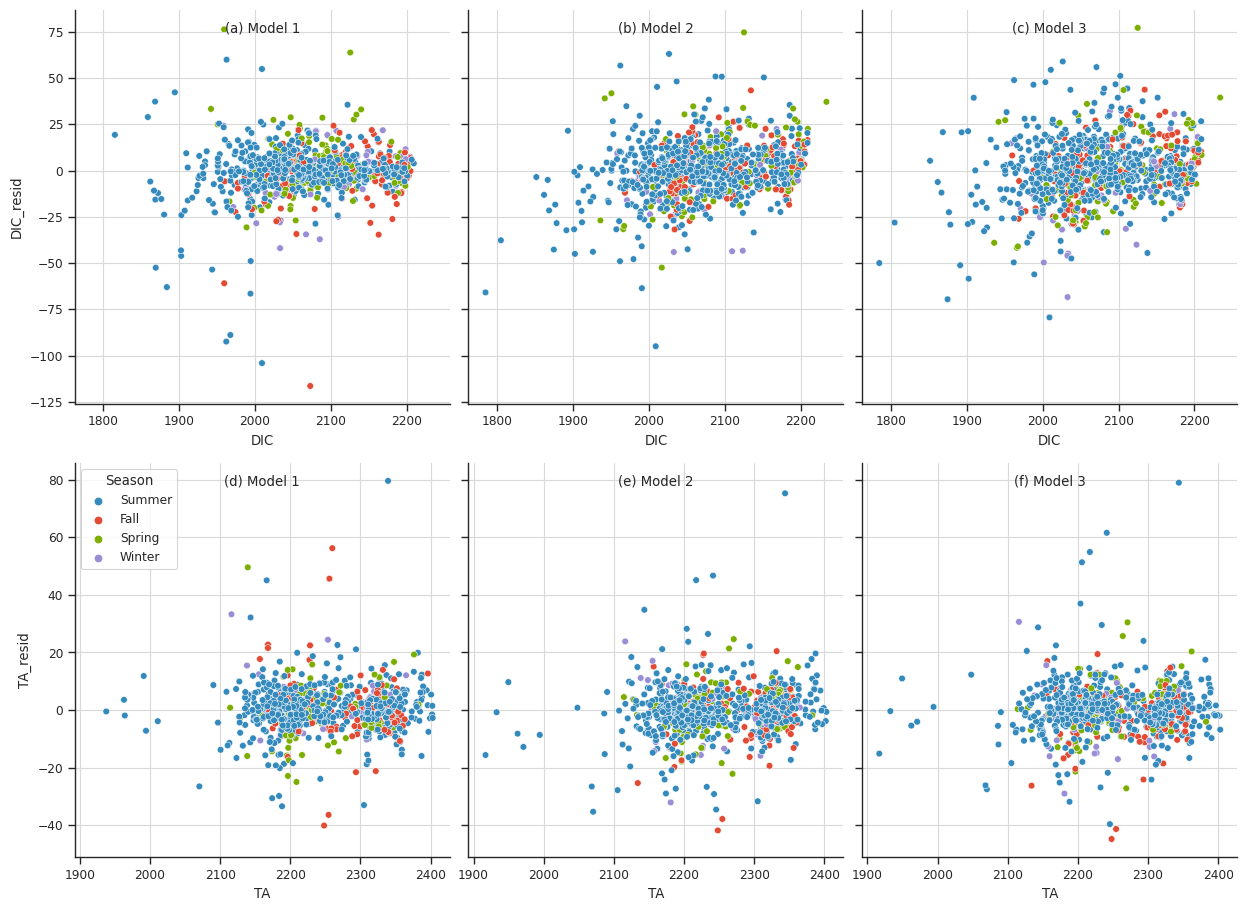

In [61]:
fig, axs = plt.subplots(2, 3, sharex='row', sharey='row', figsize=(15, 11))
fig.subplots_adjust(wspace=0.05, hspace=0.15)
for df, ax, l in zip([df_merged, df_merged_noO2, df_merged_no_sat], axs[0], [False, False, False]):
    _ = sns.scatterplot(x='DIC', y='DIC_resid', data=df, hue='Season', legend=l, ax=ax)
for df, ax, l in zip([df_merged, df_merged_noO2, df_merged_no_sat], axs[1], [True, False, False]):
    _ = sns.scatterplot(x='TA', y='TA_resid', data=df, hue='Season', legend=l, ax=ax)
labels = ['(a) Model 1', '(b) Model 2', '(c) Model 3', '(d) Model 1', '(e) Model 2', '(f) Model 3']
for ax, label in zip(axs.ravel(), labels):
    _ = ax.text(0.5, 0.97, '{}'.format(label), transform=ax.transAxes, ha='center', va='top')
sns.despine(fig)

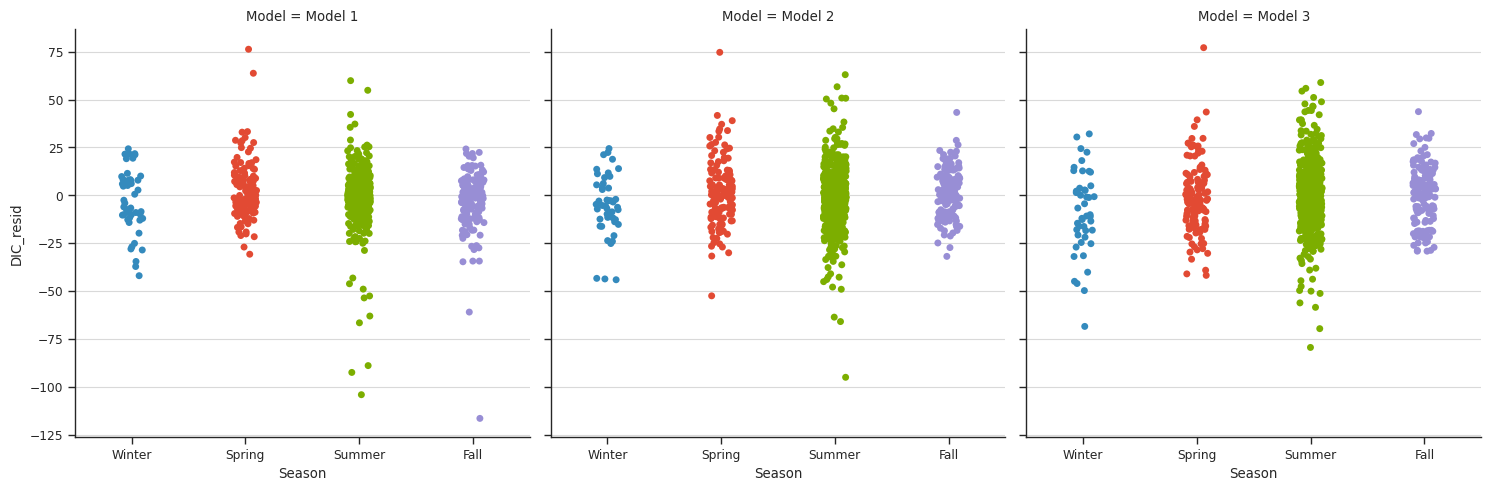

In [62]:
vlist = ['Season', 'DIC_resid', 'TA_resid']
df_resid = pd.concat([df_merged[vlist], df_merged_noO2[vlist], df_merged_no_sat[vlist]],
                         keys=['Model 1', 'Model 2', 'Model 3'], names=['Model', 'Row'])
df_resid = df_resid.reset_index(level=0).reset_index(drop=True)

order = ['Winter','Spring','Summer','Fall']
g = sns.catplot(x='Season', y='DIC_resid', col='Model', order=order, data=df_resid)

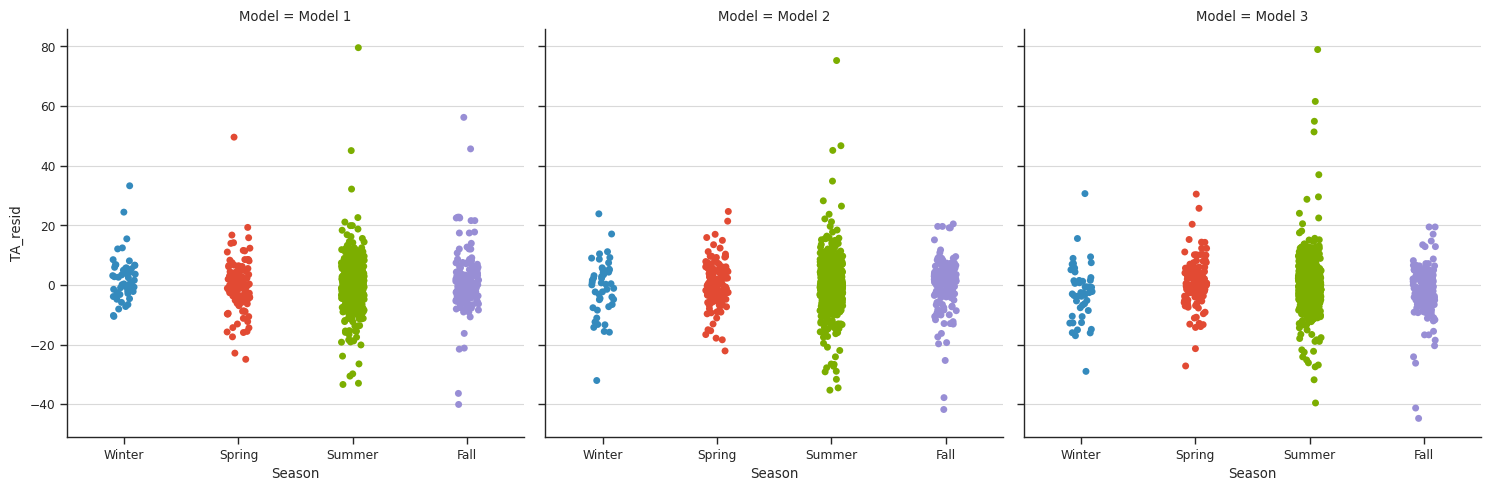

In [63]:
g = sns.catplot(x='Season', y='TA_resid', col='Model', order=order, data=df_resid)

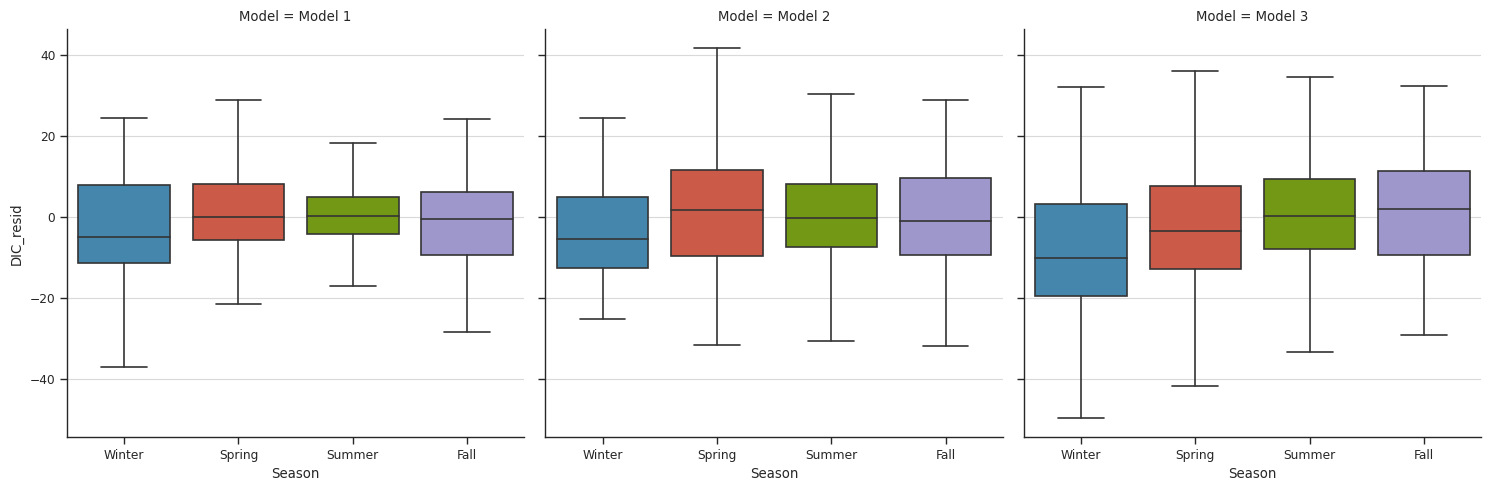

In [64]:
g = sns.catplot(x='Season', y='DIC_resid', col='Model', kind='box', order=order, showfliers=False, data=df_resid)

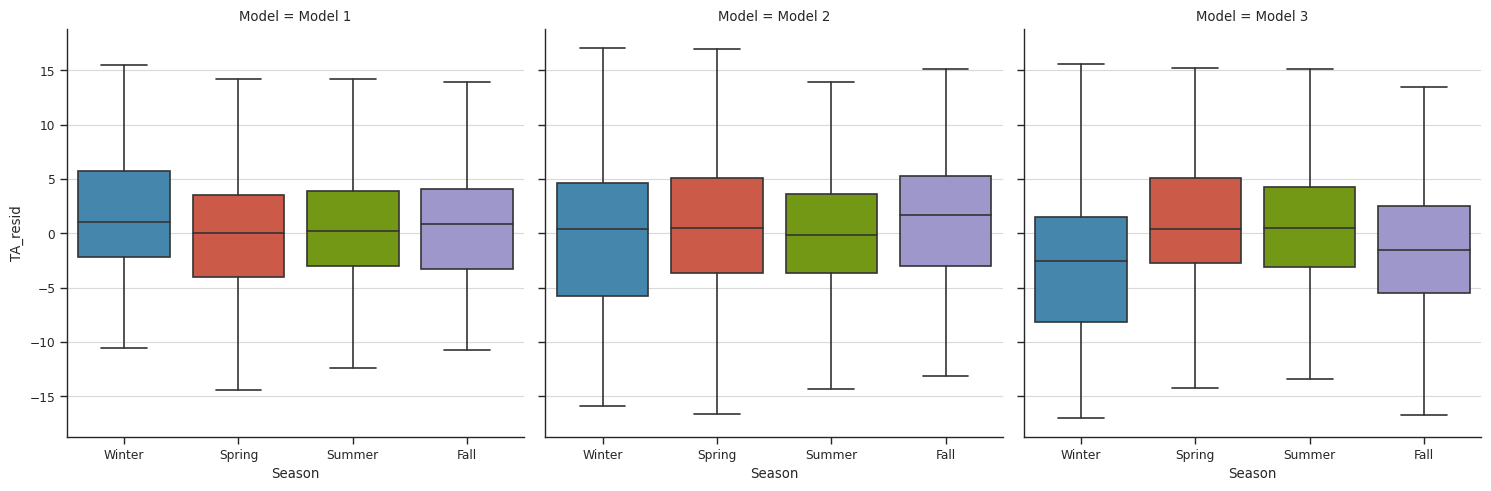

In [65]:
g = sns.catplot(x='Season', y='TA_resid', col='Model', kind='box', order=order, showfliers=False, data=df_resid)

#### RMSE values per season

In [66]:
def rmse_seasons(df_in):
    rmse_dict = {}
    rmse_dict['DIC'] = {}
    rmse_dict['TA'] = {}
    for s in ['Winter','Spring','Summer','Fall']:
        df = df_in[df_in.Season==s]
        rmse_dict['DIC'][s] = mean_squared_error(df.DIC.values, df.DIC_pred.values, squared=False)
        rmse_dict['TA'][s] = mean_squared_error(df.TA.values, df.TA_pred.values, squared=False)
        
    return pd.DataFrame(rmse_dict)

print('Model 1')
rmse_seasons(df_merged).style.format('{:.3f}')

Model 1


,DIC,TA
Winter,16.426,8.139
Spring,14.920,8.458
Summer,13.258,8.133
Fall,15.678,10.402


In [67]:
print('Model 2')
rmse_seasons(df_merged_noO2).style.format('{:.3f}')

Model 2


,DIC,TA
Winter,16.634,9.553
Spring,17.572,7.560
Summer,15.279,8.721
Fall,12.556,8.969


In [68]:
print('Model 3')
rmse_seasons(df_merged_no_sat).style.format('{:.3f}')

Model 3


,DIC,TA
Winter,22.906,10.067
Spring,18.068,7.825
Summer,16.636,8.998
Fall,15.145,8.997
